#  Прогнозирование заказов такси

Компания «Такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План проекта:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

In [62]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from math import *

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

In [63]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [65]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Выводы:** Данные загружены. Таблица состоит из 26496 объектов. Содержит количество заказов в единицу времени. Данные представлены за март-август 2018 года

## Анализ

<font color='blue' size=3><b>Ресемплирование</b></font>

In [66]:
data = data.resample('1H').sum() #ресемплирование по 1 часу

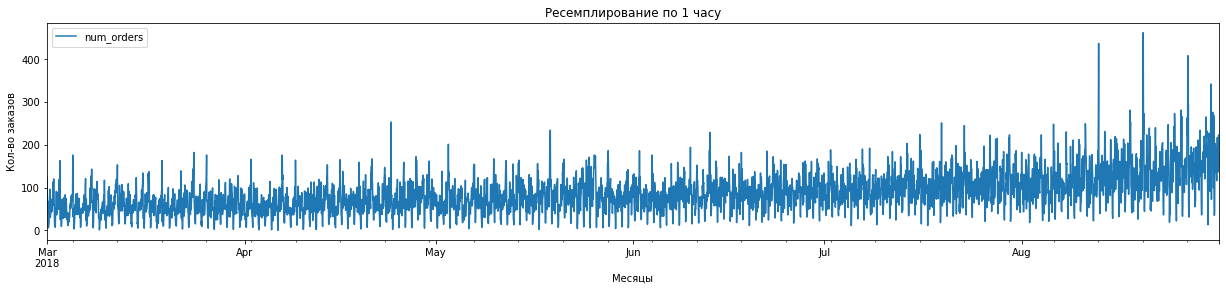

In [67]:
figsize = (21,4) #график ресемплированных данных
data.plot(figsize=figsize)
plt.title('Ресемплирование по 1 часу')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

In [68]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Вывод:** За 1 час в среднем было 84 заказа. Стандартное отклонение 45 заказов. Всего в данных есть 4416 часов.

<font color='blue' size=3><b>Скользящее среднее</b></font>

In [69]:
df = data.copy() #создадим копию наших данных для анализа

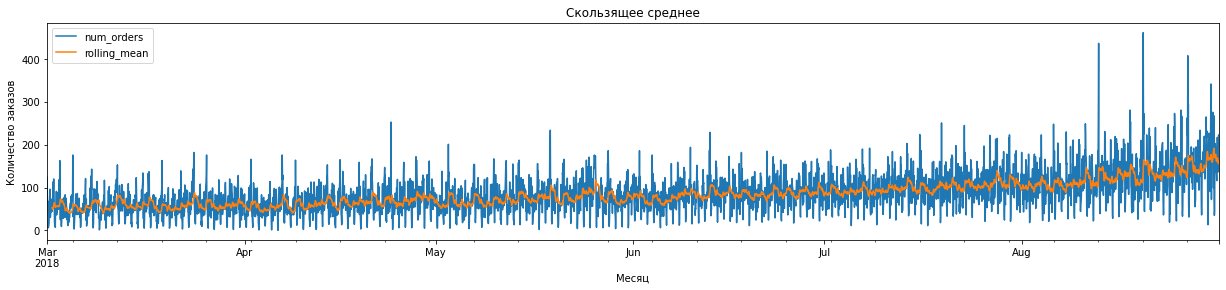

In [70]:
df['rolling_mean'] = df.rolling(20).mean() #скользящее среднее
df.plot(figsize=figsize)
plt.title('Скользящее среднее')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

<font color='blue' size=3><b>Скользящее стандартное отклонение</b></font>

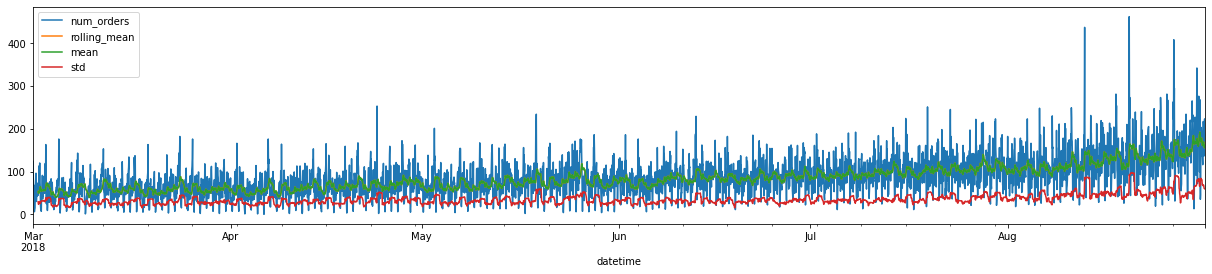

In [71]:
df['mean'] = df['num_orders'].rolling(20).mean()
df['std'] = df['num_orders'].rolling(20).std()
df.plot(figsize=figsize)
plt.show()

Построен график, сглаживающий значения - скользящее среднее. Тренд уже виден: к августу количество закаов растет.

График **Скользящее стандартное отклонение** показывает, что процесс не стационарный, так как его распределение растет, хотя и не значительно, а так же растет среднее значение.

<font color='blue' size=3><b>Тренды и сезонность</b></font>

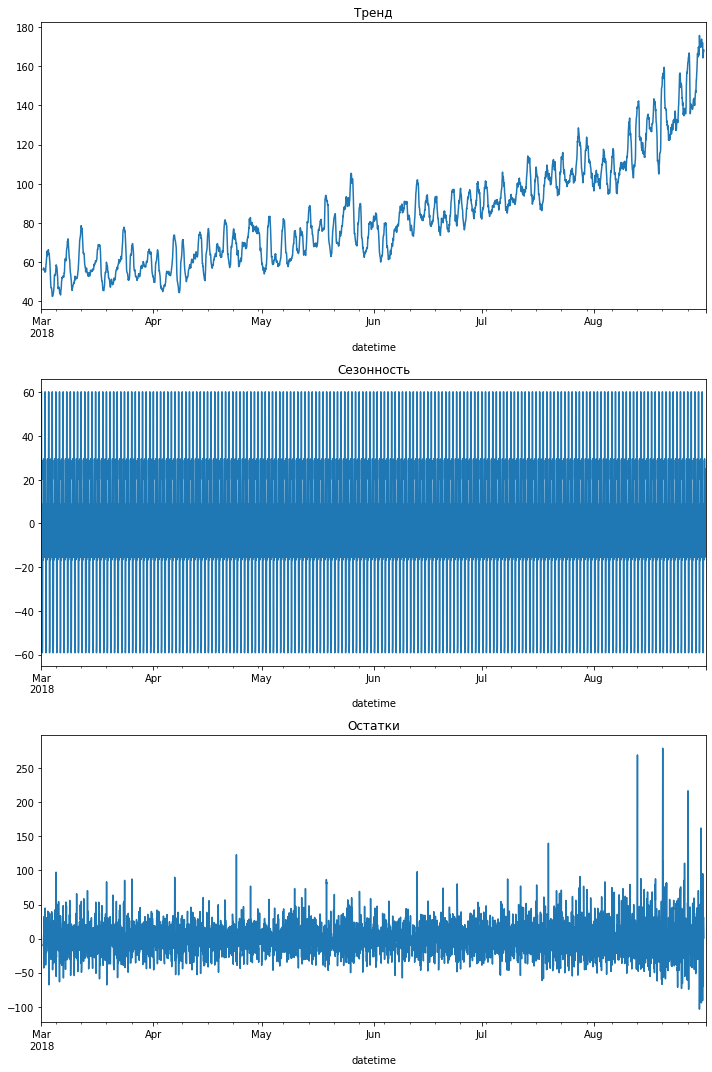

In [72]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(10, 15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() чтобы получить текущие оси
decomposed.trend.plot(ax=plt.gca()) #тренд
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # сезонность
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # остатки
plt.title('Остатки')
plt.tight_layout()

**Вывод:** построены три графика. График "Тренд" показывает очевидный тренд на рост заказов к концу периода. Сезонность в рамках данного периода отстутвует. График остатко показывает, что к концу периода возрастает разброс значений.

<font color='blue' size=3><b>Исследования более коротких интервалов</b></font>

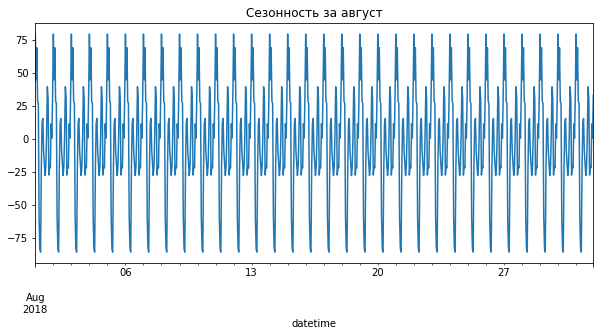

In [73]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-31']) #за месяц

plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca()) # сезонность
plt.title('Сезонность за август');

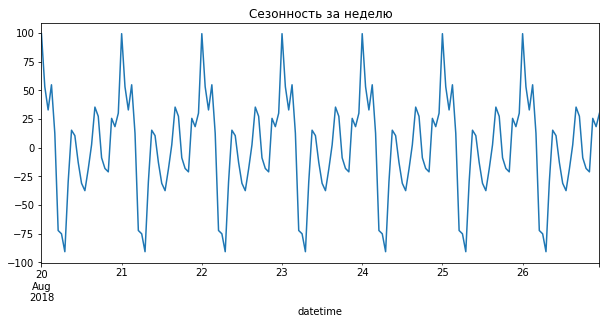

In [74]:
decomposed = seasonal_decompose(data['2018-08-20':'2018-08-26']) #за неделю

plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca()) # сезонность
plt.title('Сезонность за неделю');

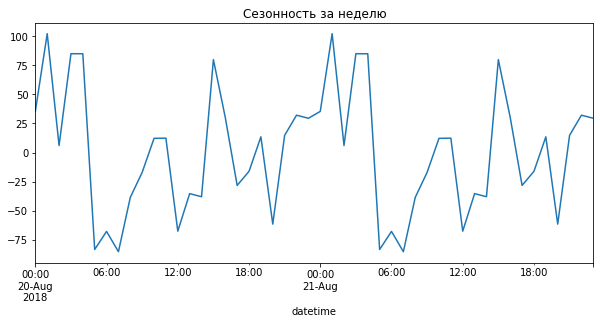

In [75]:
decomposed = seasonal_decompose(data['2018-08-20':'2018-08-21']) #за 2 дня

plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca()) # сезонность
plt.title('Сезонность за неделю');

**Вывод:** Исследование более коротнких интервалов показало, что сезонность прослеживается только в течение дня. К 6 часам утра и с 12 до 13 часов количство заказов падает. Максимальное количество заказов около 15 часов и в полночь. Много заказов ночью. Скорее всего, это можно объяснить тем, что ночью не ходит общественный транспорт и до точки назначения можно добраться только на такси.

<font color='blue' size=3><b>Разности временного ряда</b></font>

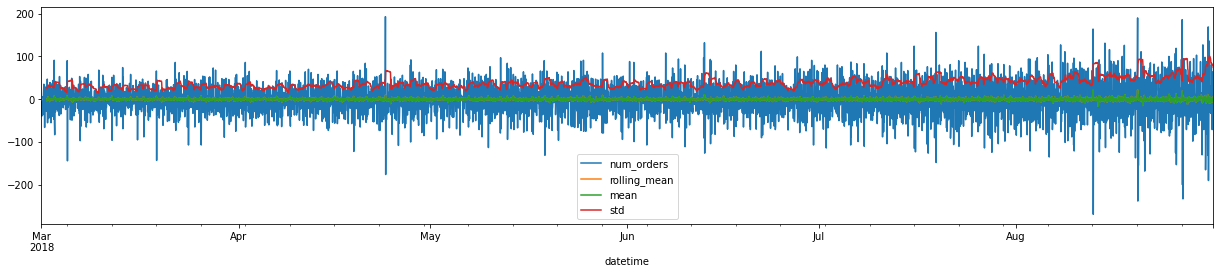

In [76]:
df -= df.shift()
df['mean'] = df['num_orders'].rolling(20).mean()
df['std'] = df['num_orders'].rolling(20).std()
df.plot(figsize=figsize)
plt.show()

**Вывод:** 

Проведен анализ временного ряда данных. 
В ходе анализа установлено, что за 1 час в среднем было 84 заказа. Стандартное отклонение 45 заказов. Всего в данных есть 4416 часов.

Построен график, сглаживающий значения - скользящее среднее. График **Скользящее стандартное отклонение** показывает, что процесс не стационарный, так как его распределение растет, хотя и не значительно, а так же растет среднее значение.

График "Тренд" показывает очевидный тренд на рост заказов к концу периода. Сезонность в рамках данного периода отстутвует. График остатков показывает, что к концу периода возрастает разброс значений.

График **Разности временного ряда** показывает, что нам удалось сделать временной ряд более стационарным. Исследование более коротких интервалов показывает, что есть сезонность в течение дня. К 6 часам утра и с 12 до 13 часов количство заказов падает. Максимальное количество заказов около 15 часов и в полночь. Много заказов ночью. Скорее всего, это можно объяснить тем, что ночью не ходит общественный транспорт и до точки назначения можно добраться только на такси.

## Обучение

In [77]:
# функция для возвращения нового датафрейма, чтобы не изменялась глобальная переменная
def make_features(data_new, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [78]:
data_final = make_features(data, 48, 24)
data_final

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,164.875000
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,167.541667
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,168.041667


In [79]:
train, test = train_test_split(data_final, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [80]:
train = train.dropna()

In [81]:
train_x = train.drop(['num_orders'], axis=1) #признаки для обучения
train_y = train['num_orders'] #целевой признак

test_x = test.drop(['num_orders'], axis=1)
test_y = test['num_orders']

**LinearRegression**

In [82]:
model_lr = LinearRegression() # обучим модель

In [83]:
%%time
params_lr = {
            'fit_intercept':[True, False],
            'copy_X':[True, False]
}

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [84]:
tss = TimeSeriesSplit(n_splits=3).split(train_x)

In [85]:
grid_lr = GridSearchCV(model_lr, param_grid=params_lr, cv=tss, scoring='neg_root_mean_squared_error')

In [86]:
grid_lr.fit(train_x, train_y) 
grid_lr.best_params_

{'copy_X': True, 'fit_intercept': False}

In [87]:
def metric_rmse(model):
    rmse_train = abs(model.best_score_)
    return rmse_train   

In [88]:
print("RMSE на кросс-валидации:", round(metric_rmse(grid_lr),2))

RMSE на кросс-валидации: 25.02


**DecisionTreeRegressor**

In [89]:
model_dt = DecisionTreeRegressor(random_state=13)

In [90]:
%%time
params_dt = {
    'max_leaf_nodes': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'splitter': ['best', 'random']
}
tss = TimeSeriesSplit(n_splits=3).split(train_x)
grid_dt = GridSearchCV(model_dt, param_grid=params_dt, cv=tss, 
                       scoring='neg_root_mean_squared_error').fit(train_x, train_y) 
grid_dt.best_params_

CPU times: user 1.97 s, sys: 16.2 ms, total: 1.99 s
Wall time: 1.99 s


{'max_depth': 4, 'max_leaf_nodes': 50, 'splitter': 'random'}

In [91]:
print("RMSE на кросс-валидации:", round(metric_rmse(grid_dt),2))

RMSE на кросс-валидации: 30.51


**RandomForestRegressor**

In [92]:
model_rf = RandomForestRegressor(random_state=13)

In [93]:
%%time
params_rf = {
    'n_estimators': [10, 20, 30],
    'max_depth': [4, 6, 10, 12],
    'max_leaf_nodes': [4, 6, 10, 12]
}
tss = TimeSeriesSplit(n_splits=3).split(train_x)
grid_rf = GridSearchCV(model_rf, param_grid=params_rf, cv=tss, 
                       scoring='neg_root_mean_squared_error').fit(train_x, train_y) 
grid_rf.best_params_

CPU times: user 44.9 s, sys: 152 ms, total: 45 s
Wall time: 45.2 s


{'max_depth': 10, 'max_leaf_nodes': 12, 'n_estimators': 30}

In [95]:
print("RMSE на кросс-валидации:", round(metric_rmse(grid_rf),2))

RMSE на кросс-валидации: 27.75


**LGBMRegressor**

In [96]:
model_lgb = lgb.LGBMRegressor(random_state=13)

In [97]:
%%time
params_lgb = {
    'num_leaves': [2,5,10], 
    'n_estimators': [10,20,30],
    'max_depth': [5, 10]
}
tss = TimeSeriesSplit(n_splits=3).split(train_x)
grid_lgb = GridSearchCV(model_lgb, param_grid=params_lgb, cv=tss, 
                       scoring='neg_root_mean_squared_error').fit(train_x, train_y) 
grid_lgb.best_params_

CPU times: user 19 s, sys: 0 ns, total: 19 s
Wall time: 19.1 s


{'max_depth': 5, 'n_estimators': 30, 'num_leaves': 10}

In [98]:
print("RMSE на кросс-валидации:", round(metric_rmse(grid_lgb),2))

RMSE на кросс-валидации: 26.42


**CatBoostRegressor**

In [99]:
model_cbr = CatBoostRegressor(loss_function="RMSE", learning_rate=0.5, verbose=False) 

In [100]:
param_cat = {'depth':[5,10], 
             'learning_rate':np.arange(0.1,1)}

In [101]:
%%time
tss = TimeSeriesSplit(n_splits=3).split(train_x)
grid_cbr = GridSearchCV(model_cbr, param_cat, cv=tss, scoring='neg_root_mean_squared_error')
grid_cbr.fit(train_x, train_y, verbose=10)
grid_cbr.best_params_

0:	learn: 28.0392976	total: 53.2ms	remaining: 53.1s
10:	learn: 20.9875930	total: 94.9ms	remaining: 8.53s
20:	learn: 18.3604767	total: 136ms	remaining: 6.36s
30:	learn: 17.0077545	total: 177ms	remaining: 5.53s
40:	learn: 16.1036993	total: 218ms	remaining: 5.1s
50:	learn: 15.2501872	total: 261ms	remaining: 4.85s
60:	learn: 14.6801980	total: 302ms	remaining: 4.65s
70:	learn: 13.9900935	total: 349ms	remaining: 4.56s
80:	learn: 13.4397551	total: 388ms	remaining: 4.41s
90:	learn: 12.8384219	total: 431ms	remaining: 4.3s
100:	learn: 12.4322375	total: 472ms	remaining: 4.2s
110:	learn: 11.8216830	total: 513ms	remaining: 4.11s
120:	learn: 11.4067310	total: 556ms	remaining: 4.04s
130:	learn: 11.0848723	total: 599ms	remaining: 3.97s
140:	learn: 10.6739646	total: 642ms	remaining: 3.91s
150:	learn: 10.2655471	total: 684ms	remaining: 3.85s
160:	learn: 9.9218756	total: 726ms	remaining: 3.79s
170:	learn: 9.6570768	total: 769ms	remaining: 3.73s
180:	learn: 9.3651083	total: 810ms	remaining: 3.67s
190:	lea

{'depth': 5, 'learning_rate': 0.1}

In [102]:
print("RMSE на кросс-валидации:", round(metric_rmse(grid_cbr),2))

RMSE на кросс-валидации: 25.36


**Выберем лучшую модель**

In [103]:
tab_res = pd.DataFrame(
    data=[('LogisticRegression', '7.39 µs', abs(grid_lr.best_score_)), 
         ('DecisionTreeRegressor', '1.99 s', abs(grid_dt.best_score_)),
         ('RandomForestRegressor', '44.6 s', abs(grid_rf.best_score_)),
         ('LGBMRegressor', '12.2 s', abs(grid_lgb.best_score_)),
         ('CatBoostRegressor', '4min 32s', abs(grid_cbr.best_score_))
         ], 
    columns=['Model', 'Time_fit', 'RMSE'])
tab_res

,Model,Time_fit,RMSE
0,LogisticRegression,7.39 µs,25.015128
1,DecisionTreeRegressor,1.99 s,30.510291
2,RandomForestRegressor,44.6 s,27.745862
3,LGBMRegressor,12.2 s,26.421677
4,CatBoostRegressor,4min 32s,25.356080


**Вывод:** лучший показатель RMSE показала модель **LogisticRegression**. Так же она имеет лучший показатель по времени обучения.

## Тестирование

Протестируем лучшую модель на тестовой выборке.

In [105]:
predicted = grid_lr.predict(test_x) # сделаем предсказания для тестовой выборки
rmse_test = sqrt(mean_squared_error(test_y, predicted))
rmse_test

42.71212869919013

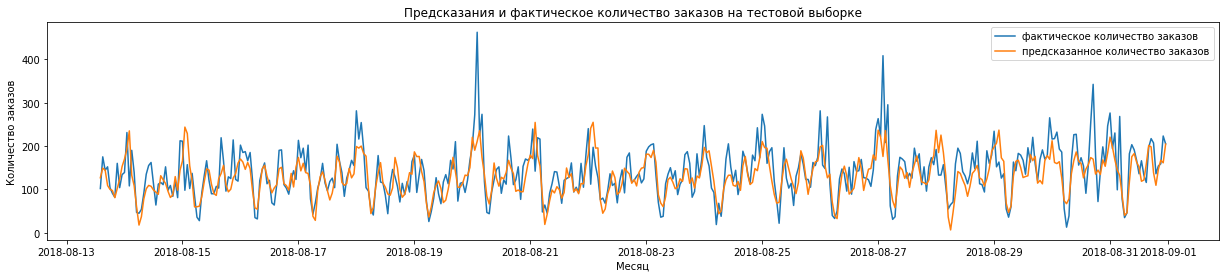

In [106]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(test_y.index, test_y, label='фактическое количество заказов')
ax.plot(test_y.index, predicted, label='предсказанное количество заказов')
plt.title('Предсказания и фактическое количество заказов на тестовой выборке')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

## Выводы

Проведен анализ временного ряда полученных данных. В ходе анализа установлено, что за 1 час в среднем было 84 заказа. Стандартное отклонение 45 заказов. Всего в данных есть 4416 часов.

Построен график, сглаживающий значения - скользящее среднее. График Скользящее стандартное отклонение показывает, что процесс не стационарный, так как его распределение растет, хотя и не значительно, а так же растет среднее значение. График "Тренд" показывает очевидный тренд на рост заказов к концу периода. Сезонность в рамках данного периода отстутвует. График остатков показывает, что к концу периода возрастает разброс значений. Исследование сезонности более коротких промежутков показало, что есть сезонность в течение дня. К 6 часам утра и с 12 до 13 часов количство заказов падает. Максимальное количество заказов около 15 часов и в полночь. Много заказов ночью. 

Было преведено обучение пяти моделей: 
- LogisticRegression
- DecisionTreeRegressor
- RandomForestRegressor
- LGBMRegressor
- CatBoostRegressor

По результатам обучения лучший показатель метрики RMSE = 25.015 показала модель LogisticRegression.

Преведенное тестирование модели на тестовых данных показало результат 42.71, что ниже показателя, обозначенного в ТЗ. Таким образом, для предсказания этого временного ряда лучше использовать модель LogisticRegression.